<a href="https://colab.research.google.com/github/Fjoru/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Prediction of tumor grade in brain cancer
By Jessica Barends, Gonnie van Erp, Erik Kemper en Carlijn Oerlemans



## Set-up
Getting the dataset and used packages.

In [174]:
# Run install for use in colab environment
!pip install --upgrade pip
!pip install -q --upgrade git+https://github.com/Fjoru/TM10007_PROJECT
!pip install ipdb -q
!pip install seaborn
!pip install tensorflow

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


### Import section


In [0]:
import ipdb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from time import time
import itertools

# General
from sklearn.model_selection import StratifiedKFold

# Preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Feature selection
from sklearn.feature_selection import RFECV

# Feature extraction
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
import umap

# Classifiers used in random search
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV

# Evaluation metrics used
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve

# Optional 
#from sklearn import preprocessing
#from sklearn.model_selection import cross_validate
#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline
#from sklearn import model_selection

## Dataset processing
Filter the dataset for better classification results.

### Definition set
Contains all used definitions for the prepocessing of the dataset.

Load dataset

In [0]:
def load_data(splits):
  '''
  load brats database and split values from labels

  '''
  # Data loading functions.
  from brats.load_data import load_data

  data = load_data()
  print('data loaded')
  print(f'The number of samples: {len(data.index)}')
  print(f'The number of columns: {len(data.columns)}')
  data = pd.DataFrame(data)

  # split labels and values
  data_X = data.drop(columns=['label'])
  data_Y = data[['label']]
  
  # data split index forming
  Test_split = StratifiedKFold(n_splits=splits)
  
  return data_X, data_Y, Test_split

remove strings from data

In [0]:
def replace_str(i):
    '''Function to set strings into NaN within a matrix'''

    if isinstance(i, int):
          return i
    try:
        float(i)
        return float(i)
    except:
        return np.nan

remove zeros and Inf from matrix

In [0]:
def replace_inf(X_data):
    # set 0.0 as NaN
    X_data.replace(0, np.nan, inplace=True)

    # set Inf as NaN
    X_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    return X_data

remove samples with less than 60% values

In [0]:
def remove_sample(X_data, Y_data, n_value):
    # remove sample with less than n% values
    X_data = X_data.dropna(thresh=round(X_data.shape[1]*n_value))
    Y_data = Y_data.loc[X_data.index]

    return X_data, Y_data

remove samples without a label

In [0]:
def remove_labeless(X_data, Y_data):
    # remove samples without a label
    Y_data['label'].replace(np.nan, '', inplace=True)
    Y_data = Y_data[Y_data['label'].astype(bool)]
    X_data = X_data.loc[Y_data.index]

    return X_data, Y_data

Impute missing value's

In [0]:
def impute_data(X_data):
    # Add missing value's 
    Imputer = IterativeImputer(sample_posterior=True, n_nearest_features=20, random_state=0)
    X_data = Imputer.fit_transform(X_data)

    return X_data, Imputer

Scale value's

In [0]:
def scale_data(X_data):
    # scaling of values
    Scaler = RobustScaler()
    X_data = Scaler.fit_transform(X_data)

    return X_data, Scaler

### preform dataset processing
Run all preset definitions.

In [0]:
def preprocessing_data(X_design, Y_design, X_test, Y_test):
    '''
    Preprocessing step Hyperparameters:
    - Feature removal percentage
    - Sample removal percentage
    - Value imputer type
    - Normalizer type
    '''

    # remove strings from data
    X_design = X_design.applymap(func=replace_str)
    X_test = X_test.applymap(func=replace_str)

    # remove 0.0 and Inf from data
    X_design = replace_inf(X_design)
    X_test = replace_inf(X_test)
    print('unusefull values removed')

    # remove features with less than 60% values
    X_design = X_design.dropna(thresh=round(X_design.shape[0]*0.6), axis='columns')
    X_test = X_test[X_design.columns]

    # remove features and samples with less than 60% values
    X_design, Y_design = remove_sample(X_design, Y_design, n_value=0.6)
    X_test, Y_test = remove_sample(X_test, Y_test, n_value=0.6)
    print('features and samples with too little information removed')

    # remove samples without a label
    X_design, Y_design = remove_labeless(X_design, Y_design)    
    X_test, Y_test = remove_labeless(X_test, Y_test)
    print('labeless samples removed')

    # impute missing data
    X_design_imput, imputer = impute_data(X_design)
    X_test_imput = imputer.transform(X_test)
    print('remaining missing data imputed')

    # plot distribution of 6 random features, run one time to check for outliers. Thefore chosen for RobustScaler()
    # generate some integers
    #values = np.random.randint(0, X_design.shape[1], 6)
    #data_select = X_design.iloc[:,values]
    #data_select = data_select.join(Y_design)

    # plot resulting data
    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(60, 20))
    #sns.scatterplot(y=data_select.columns[0], x=data_select.columns[1], hue='label', data=data_select, ax=ax1)
    #sns.scatterplot(y=data_select.columns[2], x=data_select.columns[3], hue='label', data=data_select, ax=ax2)
    #sns.scatterplot(y=data_select.columns[4], x=data_select.columns[5], hue='label', data=data_select, ax=ax3)

    # scale the data
    X_design_scaled, scaler = scale_data(X_design_imput)
    X_test_scaled = scaler.transform(X_test_imput)
    print('data scaled')

    # Getting back to Dataframe 
    X_design = pd.DataFrame(X_design_scaled, columns=X_design.columns, index=X_design.index)
    X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    print('preprocessing finished')
    print(f'The number of samples: {len(X_design.index)+len(X_test.index)}')
    print(f'The number of columns: {len(X_design.columns)}')

    return X_design, Y_design, X_test, Y_test

## Experimental feature orientation
Determine possible options for feature selection and extraction

### Load part of dataset
Getting the design set of the data.

data loaded
The number of samples: 167
The number of columns: 725
unusefull values removed
features and samples with too little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 698


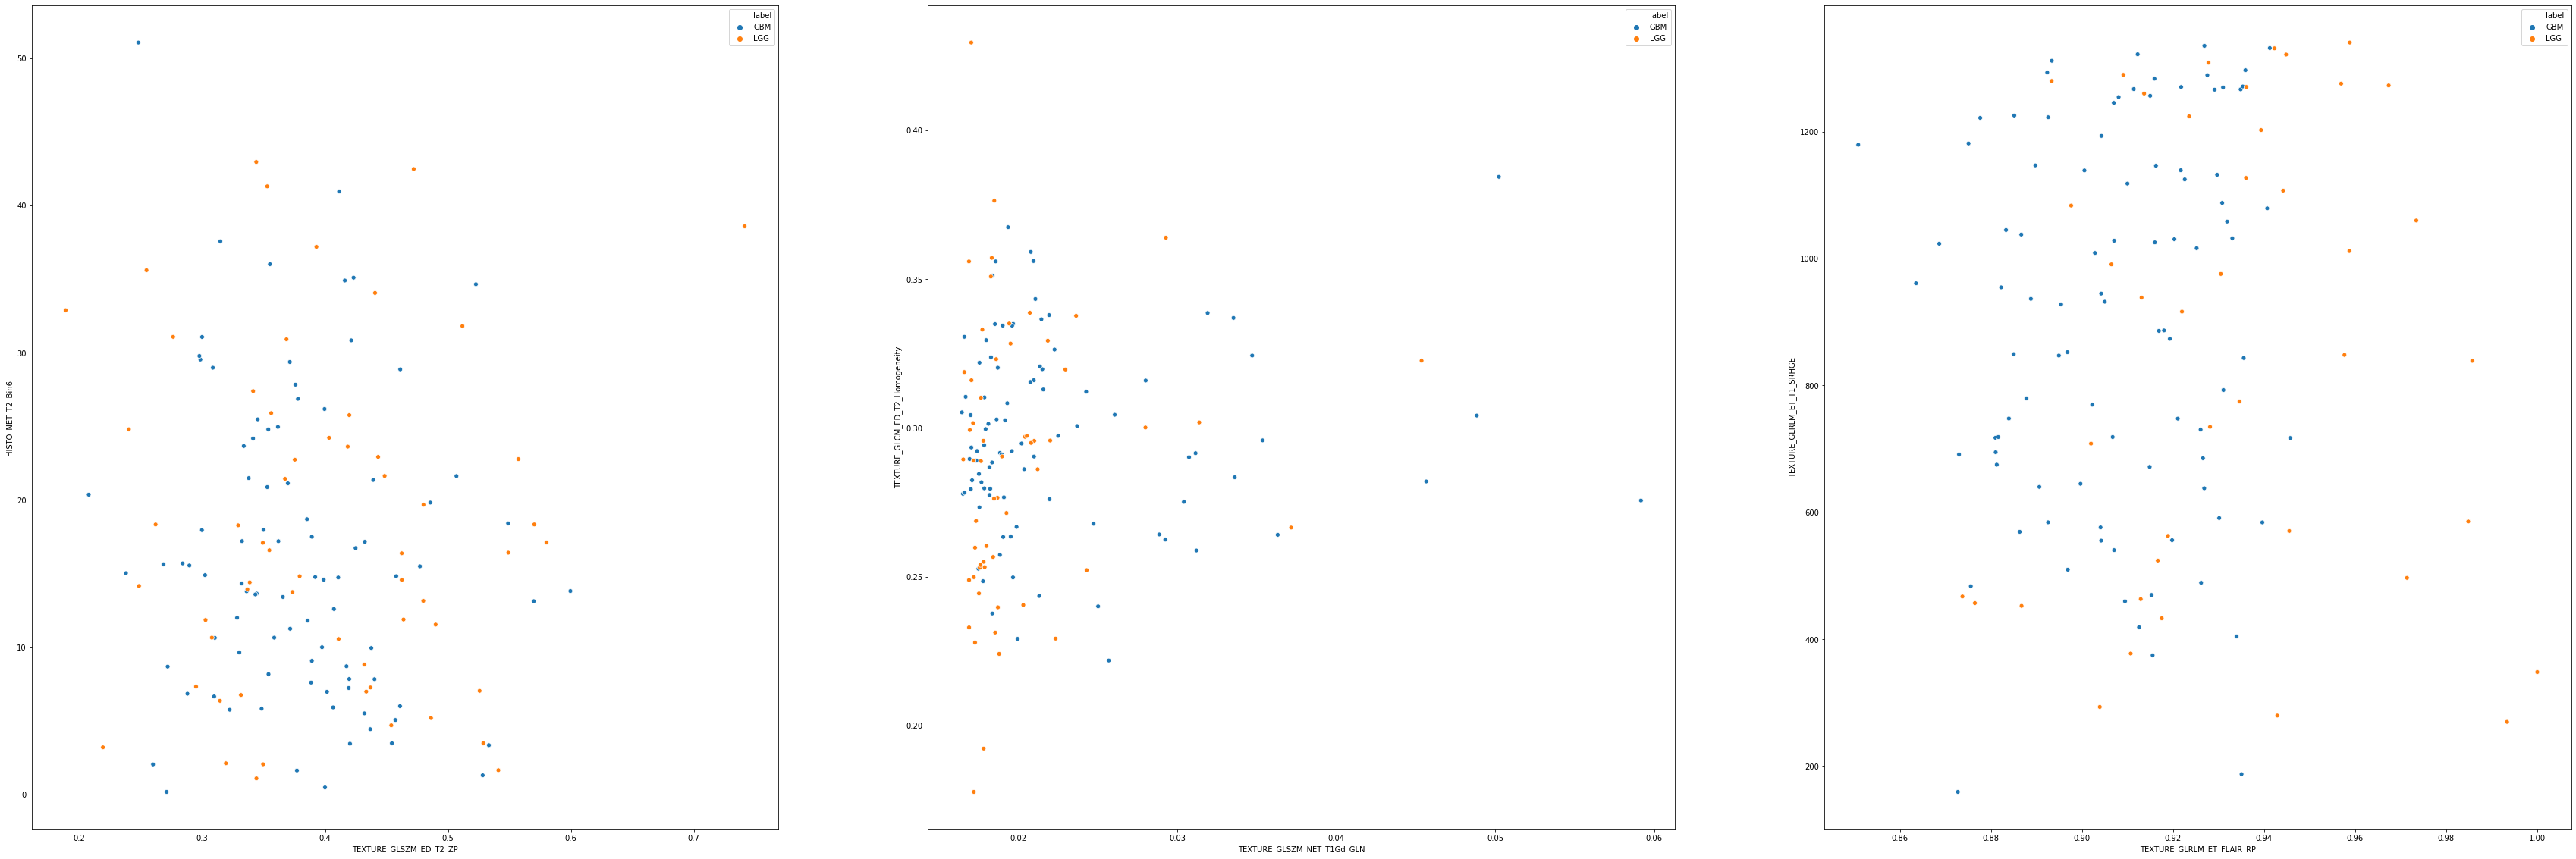

In [227]:
#load dataset
data_X, data_Y, Test_split = load_data(splits=10)

i = 0
for design_index, test_index in Test_split.split(data_X, data_Y):

    if i:
      continue
    i = 1

    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

X_design, Y_design, X_test, Y_test = preprocessing_data(X_design, Y_design, X_test, Y_test)

In [0]:
print(X_design, Y_design)


              VOLUME_ET  VOLUME_NET  ...  TGM_Cog_Z_1   TGM_T_1
ID                                   ...                       
TCGA-02-0064   0.306650   -0.149335  ...    -0.409811  0.412749
TCGA-02-0068  -0.131777   -0.098523  ...    -0.254765 -0.182429
TCGA-02-0069  -0.006484    0.912666  ...     0.284368  2.705034
TCGA-02-0070  -0.274249   -0.314443  ...     0.839935 -0.449039
TCGA-02-0075  -0.109278    0.247846  ...     0.451606 -0.017942
...                 ...         ...  ...          ...       ...
TCGA-HT-8018  -0.506682   -0.179239  ...    -0.849962 -0.833459
TCGA-HT-8111  -0.512206   -0.381408  ...     1.026131 -0.804997
TCGA-HT-8114  -0.282298    3.740634  ...     0.526592 -0.757509
TCGA-HT-8563  -0.181188   -0.367314  ...    -0.466627 -0.801878
TCGA-HT-A61A   0.757504    1.082333  ...    -0.592295  0.330073

[150 rows x 698 columns]              label
ID                
TCGA-02-0064   GBM
TCGA-02-0068   GBM
TCGA-02-0069   GBM
TCGA-02-0070   GBM
TCGA-02-0075   GBM
...      

### Pre-sets and Definition set
Pre-set definitions to preform the experiments.

Pre-sets

In [0]:
# Set parameters
RFE_split = 5
Train_split = 5

# make labels binary
Y_design_bin = Y_design.replace(['GBM', 'LGG'], [1, 0])

# set validation-training split
train_splitter = StratifiedKFold(n_splits=Train_split)

Selector

In [0]:
# RFE estimator
svc_linear = svm.SVC(kernel="linear")

# RFE type
rfecv_svc = RFECV(
                  estimator=svc_linear, step=1, 
                  cv=StratifiedKFold(n_splits=RFE_split), 
                  scoring='roc_auc')  

# selector list                  
selectors = ('no_rfecv', 'rfecv')         

Extractors

In [0]:
# extractors
pca_lin = KernelPCA(kernel='linear')
pca_poly = KernelPCA(kernel='poly')
pca_rbf = KernelPCA(kernel='rbf')
umapper_3 = umap.UMAP(n_neighbors=3)
umapper_5 = umap.UMAP(n_neighbors=5)
umapper_6 = umap.UMAP(n_neighbors=6)
umapper_15 = umap.UMAP(n_neighbors=15)
umapper_30 = umap.UMAP(n_neighbors=30)
tsvd = TruncatedSVD()

Cross-validation test

In [0]:
def run_feature_test(X_design, Y_design_bin, train_splitter, para_options, extractors, selector):
    # predefine variables
    results = list()
    i = 1
    t0 = time()

    # RFE types list                  
    selectors = {'no_rfecv': 0, 'rfecv': 1}
    
    # create standard classifier
    clf = svm.SVC()
    
    # run cross-validation validate, train set
    for train_index, validate_index in train_splitter.split(X_design, Y_design_bin):
        X_train = X_design.iloc[train_index]
        Y_train = Y_design_bin.iloc[train_index]
    
        X_validate = X_design.iloc[validate_index]
        Y_validate = Y_design_bin.iloc[validate_index]
        Y_validate = np.array(Y_validate)
        print(f'running split {i} of {Train_split}')
        i += 1

        # Run RFECV on split
        X_train_selected = selector.fit_transform(X_train, Y_train['label'])
        X_validate_selected = selector.transform(X_validate)
        print(f'{X_train_selected.shape[1]} features left after selection')

        for indez, row in para_options.iterrows():
            extractor=extractors[row[1]]
            component=row[2]
        
            # use selected or unselected data
            if selectors[row[0]] and X_train_selected.shape[1] > component:
                X_train_try = X_train_selected
                X_validate_try = X_validate_selected
                #print(f'rfecv done {extractor, component}')

            else:
                X_train_try = X_train
                X_validate_try = X_validate
                #print(f'no rfecv done {extractor, component}')
          
            # run selected extractor
            extractor.set_params(n_components=component)
            X_train_extracted = extractor.fit_transform(X_train_try)
            X_validate_extracted = extractor.transform(X_validate_try)
        
            # fitting standard classifier
            clf.fit(X_train_extracted, Y_train['label'])

            # Test the classifier on the test data
            scores = clf.predict(X_validate_extracted)

            # Gettin accuracy, AUC and f1-score
            accuracy = accuracy_score(Y_validate, scores)
            auc = roc_auc_score(Y_validate, scores)
            f1 = f1_score(Y_validate, scores)
            results.append({
                'accuracy': accuracy,
                'AUC': auc,
                'f1-score': f1,
                'set': f'{indez}_test'
            })

            # Test the classifier on the training data
            scores_training = clf.predict(X_train_extracted)

            # Getting the accuracy, AUC and f1-score
            accuracy = accuracy_score(Y_train, scores_training)
            auc = roc_auc_score(Y_train, scores_training)
            f1 = f1_score(Y_train, scores_training)
            results.append({
                'accuracy': accuracy,
                'AUC': auc,
                'f1-score': f1,
                'set': f'{indez}_training'
            })
        print(f'calulated options')

    # Create results dataframe
    results = pd.DataFrame(results)
    print("finished in %0.3fs" % (time() - t0))
    return results

Calculate mean and std from cross-validation

In [0]:
def cal_means(data, stats):
    stats_line = {
    'ac mean': "{:.3f}".format(data["accuracy"].mean()),
    'ac std': "{:.2f}".format(data["accuracy"].std()),
    'AUC mean': "{:.3f}".format(data["AUC"].mean()),
    'AUC std': "{:.2f}".format(data["AUC"].std()),
    'f1 mean': "{:.3f}".format(data["f1-score"].mean()),
    'f1 std': "{:.2f}".format(data["f1-score"].std())
    }
    stats_line = stats_line
    stats.append(stats_line)
    
    return stats

Calulate results from cross-validation

In [0]:
def get_results(results, para_options):
    # calculate the mean and std of each option
    test_result_stat = list()
    train_result_stat = list()

    for i in range(0, para_options.shape[0]):

        test_result = results[results['set'] == f'{i}_test']
        test_result_stat = cal_means(test_result, test_result_stat)

        train_result = results[results['set'] == f'{i}_train']
        train_result_stat = cal_means(train_result, train_result_stat)

    test_result_stat = pd.DataFrame(test_result_stat)
    train_result_stat = pd.DataFrame(train_result_stat)

    # order the results on AUC, accuracy and f1-score
    test_result_stat.sort_values(by=['AUC mean', 'ac mean', 'f1 mean'],ascending=False, inplace=True)
    test_result_stat = test_result_stat.join(para_options)

    train_result_stat.sort_values(by=['AUC mean', 'ac mean', 'f1 mean'],ascending=False, inplace=True)
    train_result_stat = train_result_stat.join(para_options)


    return test_result_stat, train_result_stat

### Orientational Experiment
Experiment with a wide variety of chosen extractors and parameters to find optima.

selected options

In [0]:
# extractor list
extractors = {'umap_3': umapper_3, 'umap_5': umapper_5, 'umap_15': umapper_15, 'umap_30': umapper_30, 'pca_lin': pca_lin, 'pca_poly': pca_poly, 'pca_rbf': pca_rbf, 'tsvd': tsvd}

#component parameters
extract_components = (2, 6, 12, 24, 48, 92)

preform feature selection and extraction test

In [0]:
#all options to test
para_options = pd.DataFrame(list(itertools.product(selectors, extractors, extract_components)))
print(f'{para_options.shape[0]} options to try')


# Run experiment
results = run_feature_test(X_design, Y_design_bin, train_splitter, para_options, extractors, rfecv_svc)

96 options to try
running split 1 of 5
126 features left after selection


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate conn

calulated options
running split 2 of 5
64 features left after selection


/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components
/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


calulated options
running split 3 of 5
114 features left after selection
calulated options
running split 4 of 5
84 features left after selection
calulated options
running split 5 of 5
55 features left after selection
calulated options
finished in 311.071s


Plot results

legend
           0       1   2
0   no_rfecv  umap_3   2
1   no_rfecv  umap_3   6
2   no_rfecv  umap_3  12
3   no_rfecv  umap_3  24
4   no_rfecv  umap_3  48
..       ...     ...  ..
91     rfecv    tsvd   6
92     rfecv    tsvd  12
93     rfecv    tsvd  24
94     rfecv    tsvd  48
95     rfecv    tsvd  92

[96 rows x 3 columns]


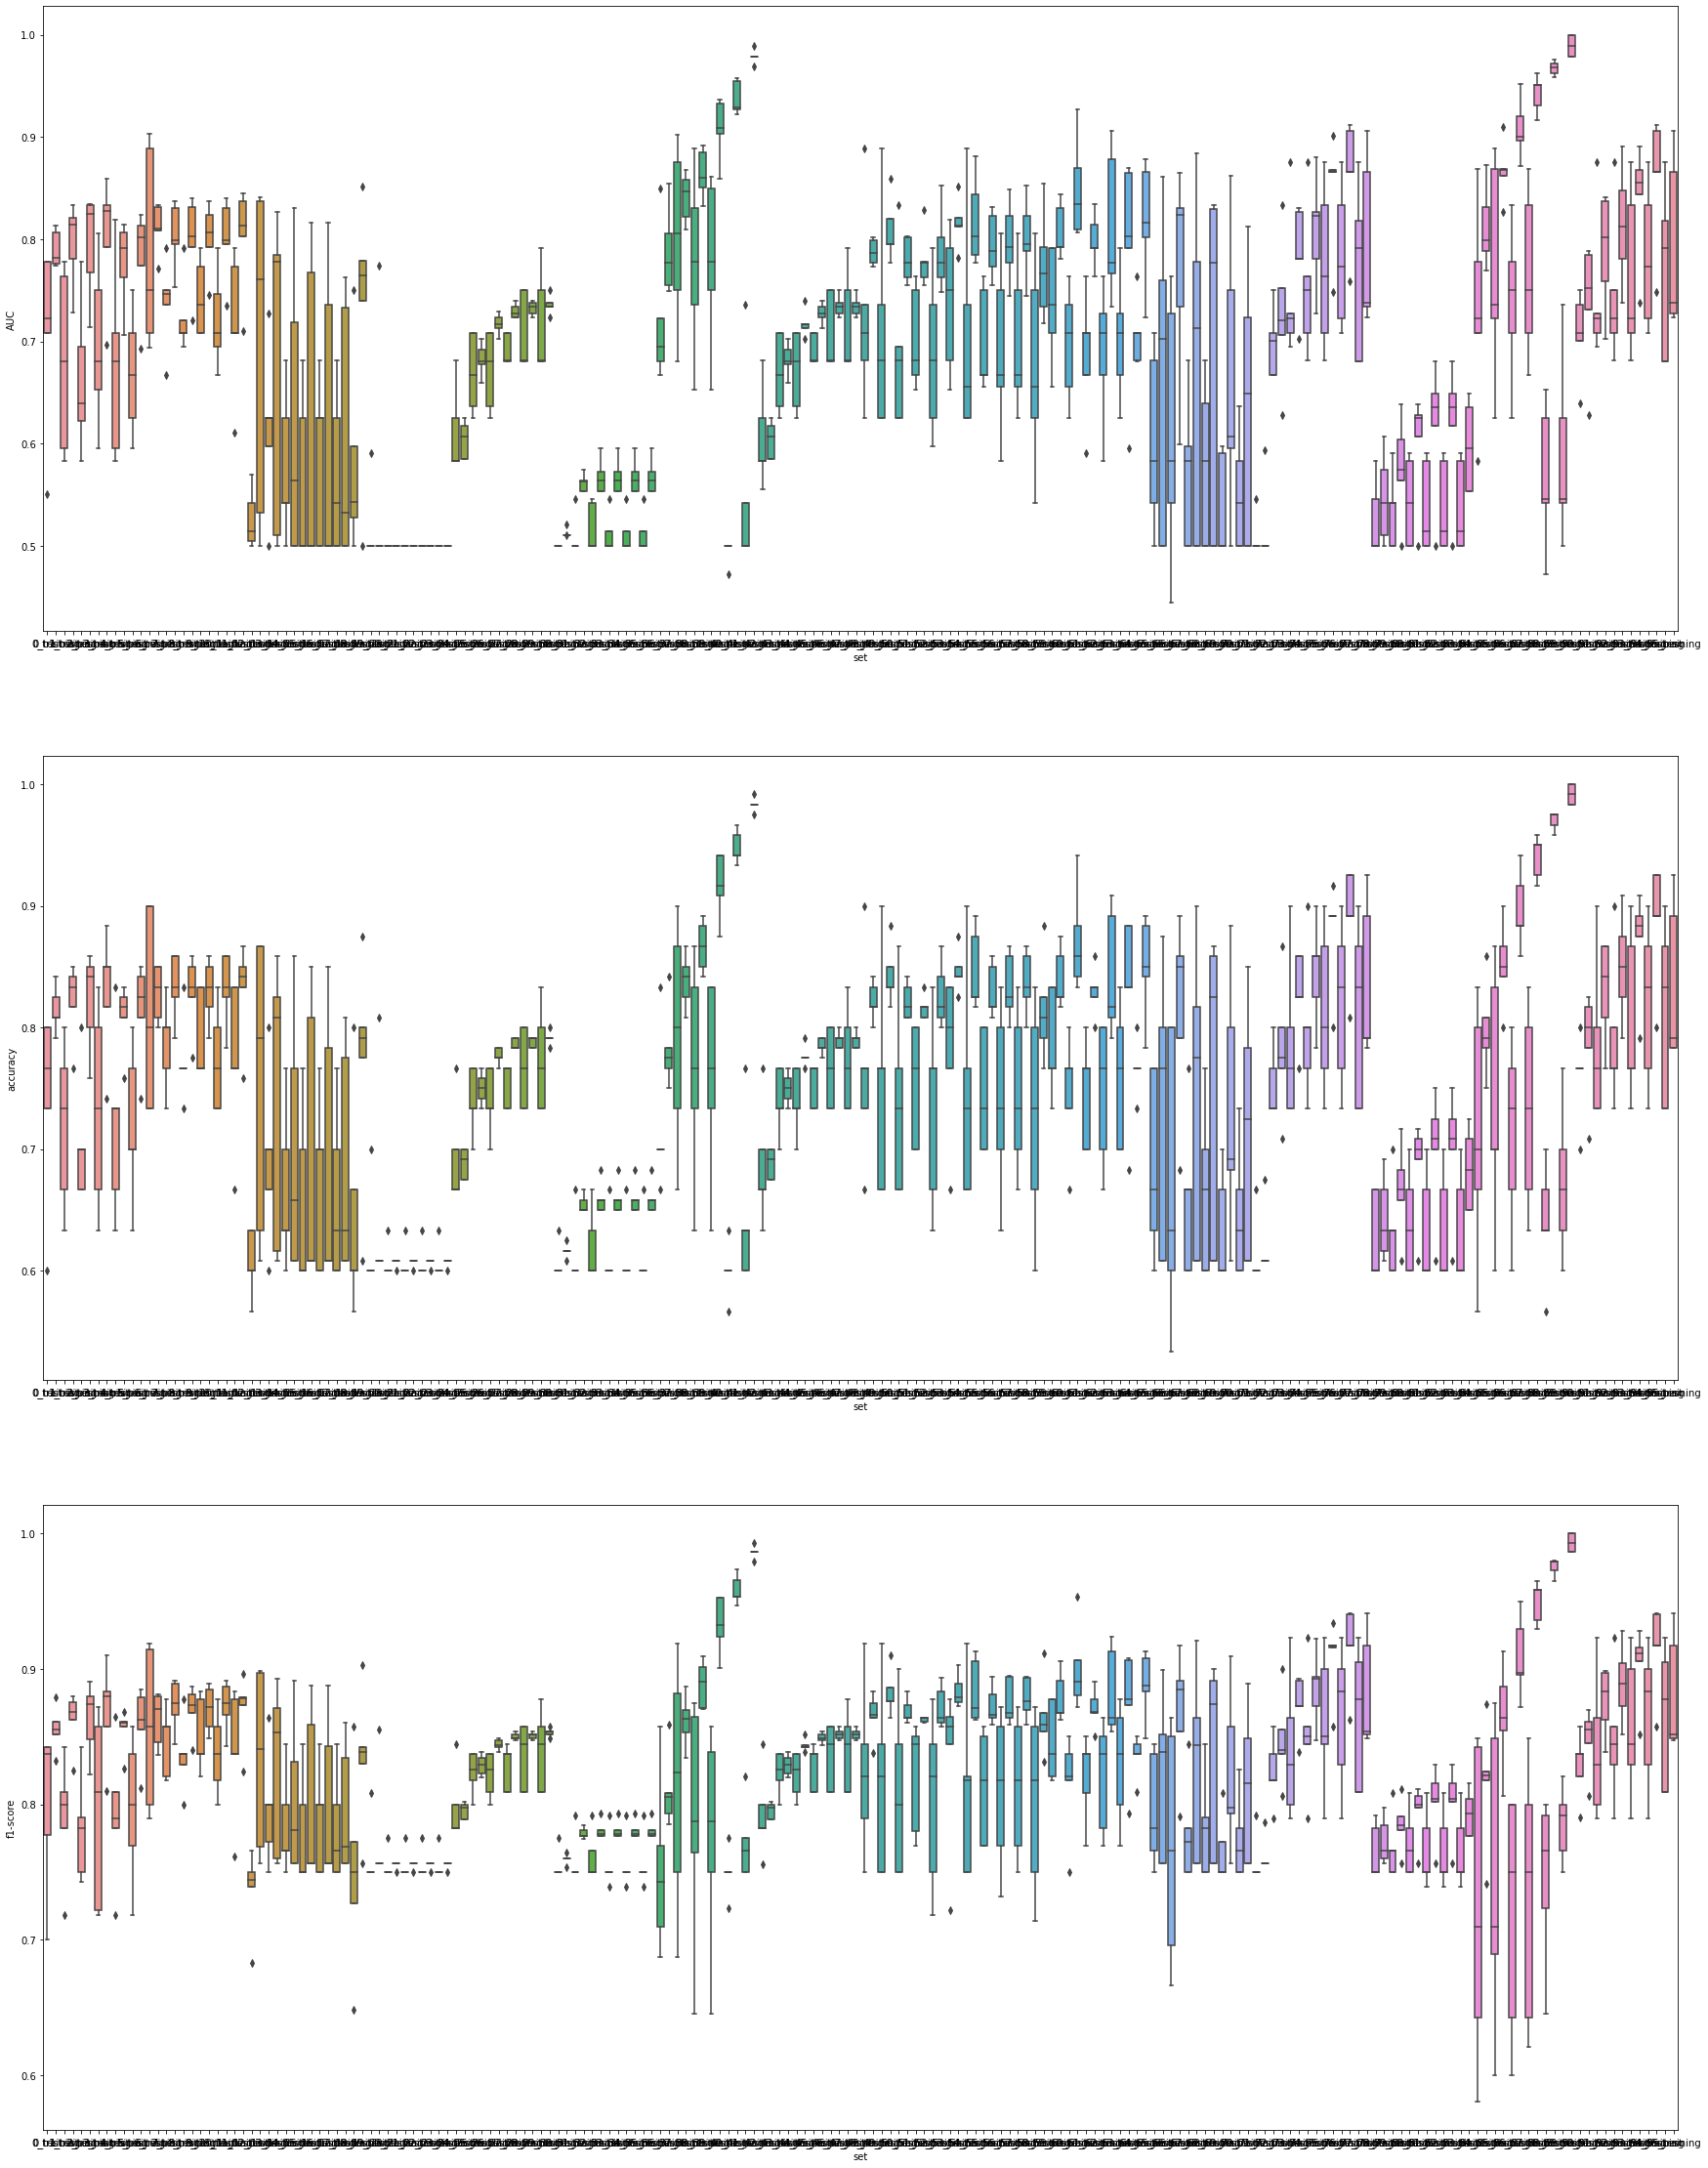

In [0]:
# plot resulting data
print('legend')
print(para_options)

f, axes = plt.subplots(3, 1, figsize=(30, 40))
sns.boxplot(y='AUC', x='set', data=results, ax=axes[0])
sns.boxplot(y='accuracy', x='set', data=results, ax=axes[1])
sns.boxplot(y='f1-score', x='set', data=results, ax=axes[2])

Determ the best options

In [0]:
test_result, train_result = get_results(results, para_options)
print('Top 20 best scoring results')
print(test_result.iloc[range(0,20)])


Top 20 best scoring results
   ac mean ac std AUC mean AUC std f1 mean f1 std         0        1   2
37   0.793   0.10    0.803    0.09   0.812   0.09  no_rfecv  pca_rbf   6
6    0.813   0.08    0.789    0.10   0.856   0.06  no_rfecv   umap_5   2
76   0.820   0.07    0.782    0.07   0.865   0.05     rfecv  pca_lin  48
94   0.820   0.07    0.782    0.07   0.865   0.05     rfecv     tsvd  48
39   0.760   0.08    0.778    0.08   0.776   0.08  no_rfecv  pca_rbf  24
38   0.767   0.09    0.777    0.09   0.788   0.09  no_rfecv  pca_rbf  12
75   0.813   0.07    0.772    0.08   0.861   0.05     rfecv  pca_lin  24
77   0.813   0.08    0.769    0.09   0.865   0.05     rfecv  pca_lin  92
95   0.813   0.08    0.769    0.09   0.865   0.05     rfecv     tsvd  92
85   0.740   0.11    0.768    0.11   0.745   0.12     rfecv  pca_rbf   6
87   0.733   0.08    0.765    0.08   0.732   0.10     rfecv  pca_rbf  24
93   0.807   0.07    0.764    0.08   0.857   0.05     rfecv     tsvd  24
74   0.800   0.06    0.

After running the code above, the following conclusions where drawn:
- There is difference between feature and no feature selection, but not similar for each option
- the PCA with a rbf kernel and no rfecv provides the highest scores, but with a high std
- the PCA with a linear kernel and rfecv also provide high scores and lower std, but only with more components
- the UMAP with 5 neighbors provides second best scores, but with a smaller std
- there is a optimum in the amount of components around the 6 and 12

With this in mind the parameter for the second test are chosen.

### Localized Experiment
Experiment with selected extractors and parameters around promising results of the Orientational Experiment.

selected options

In [0]:
# extractor list
extractors = {'umap_5': umapper_5, 'pca_lin': pca_lin, 'pca_rbf': pca_rbf}

#parameters
extract_components = (4, 6, 8, 12, 45, 48, 52, 56)

preform feature selection and extraction test

In [0]:
#all options to test
para_options = pd.DataFrame(list(itertools.product(selectors, extractors, extract_components)))
para_options = para_options.loc[[0,1,2,3,16,17,18,19,36,37,38,39]]
para_options = para_options.reset_index(drop=True)
print(f'{para_options.shape[0]} options to try')

# Run experiment
results = run_feature_test(X_design, Y_design_bin, train_splitter, para_options, extractors, rfecv_svc)

12 options to try
running split 1 of 5
126 features left after selection
calulated options
running split 2 of 5
64 features left after selection
calulated options
running split 3 of 5
114 features left after selection
calulated options
running split 4 of 5
84 features left after selection
calulated options
running split 5 of 5
55 features left after selection
calulated options
finished in 166.442s


Plot results

legend
           0        1   2
0   no_rfecv   umap_5   4
1   no_rfecv   umap_5   6
2   no_rfecv   umap_5   8
3   no_rfecv   umap_5  12
4   no_rfecv  pca_rbf   4
5   no_rfecv  pca_rbf   6
6   no_rfecv  pca_rbf   8
7   no_rfecv  pca_rbf  12
8      rfecv  pca_lin  45
9      rfecv  pca_lin  48
10     rfecv  pca_lin  52
11     rfecv  pca_lin  56


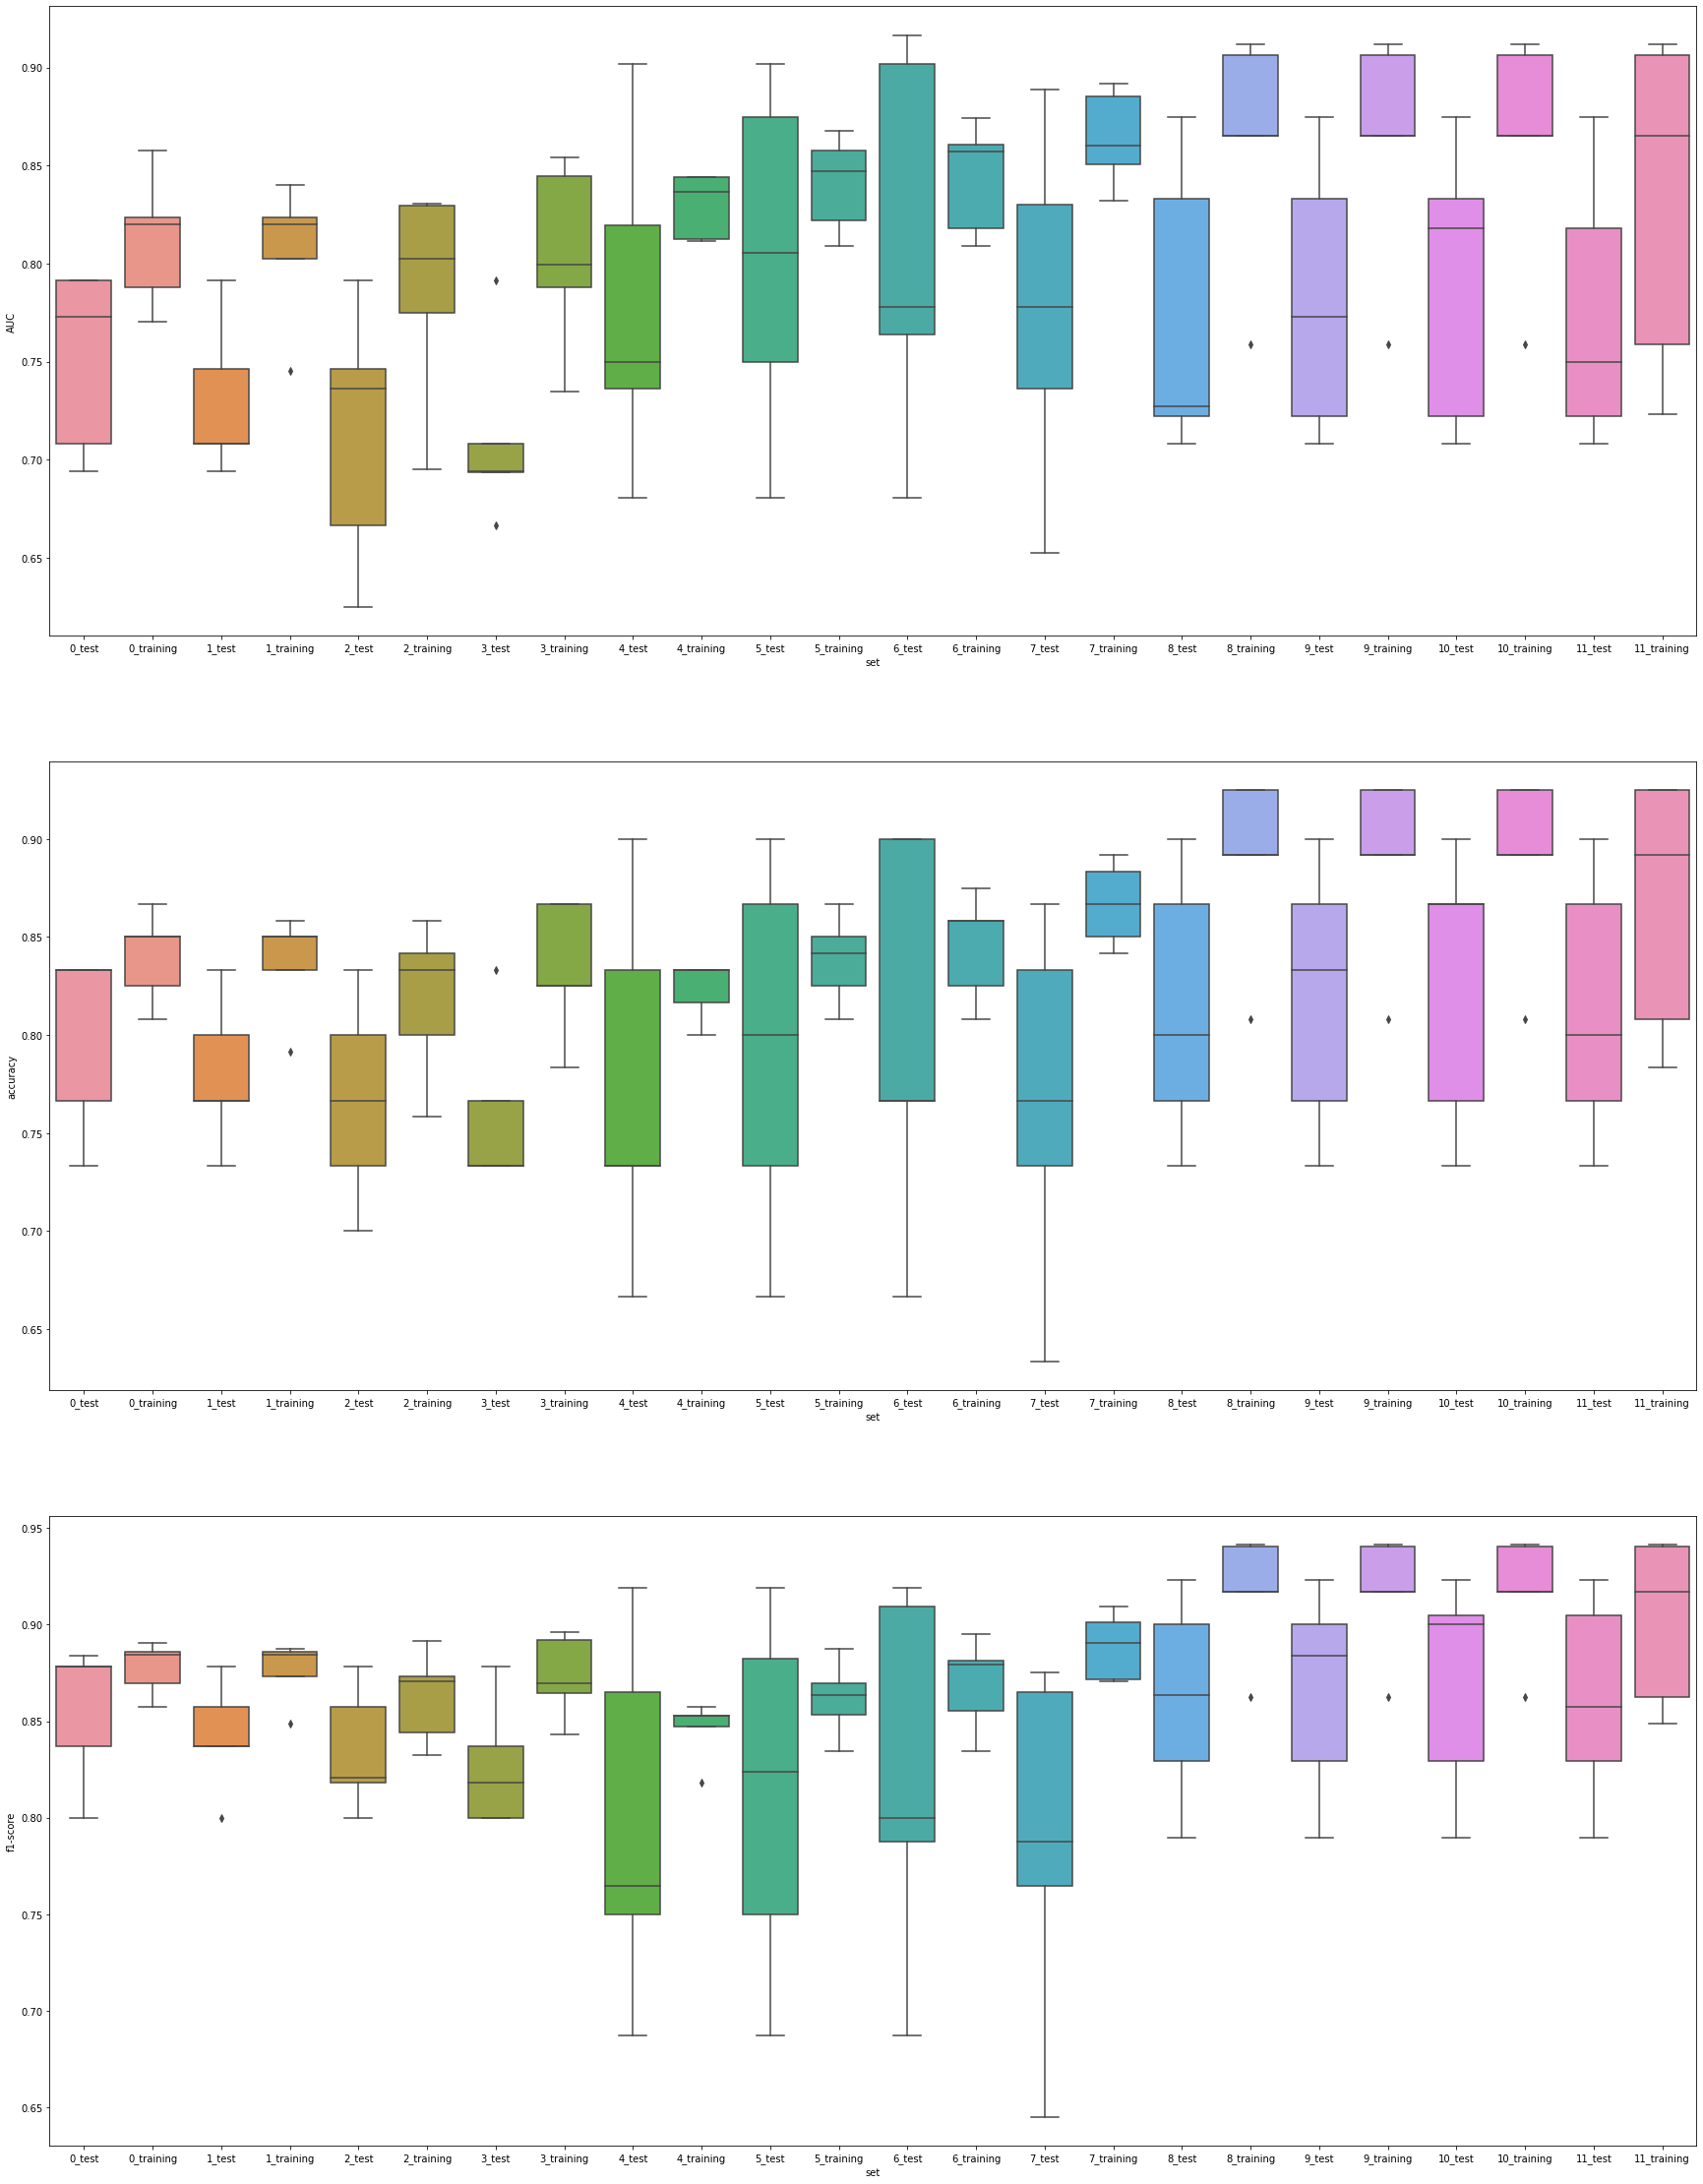

In [0]:
# plot resulting data
print('legend')
print(para_options)

f, axes = plt.subplots(3, 1, figsize=(30, 40))
sns.boxplot(y='AUC', x='set', data=results, ax=axes[0])
sns.boxplot(y='accuracy', x='set', data=results, ax=axes[1])
sns.boxplot(y='f1-score', x='set', data=results, ax=axes[2])

Determ the best options

In [0]:
test_result, train_result = get_results(results, para_options)
print(test_result)

   ac mean ac std AUC mean AUC std f1 mean f1 std         0        1   2
6    0.800   0.10    0.808    0.10   0.821   0.10  no_rfecv  pca_rbf   8
5    0.793   0.10    0.803    0.09   0.812   0.09  no_rfecv  pca_rbf   6
10   0.827   0.07    0.791    0.07   0.869   0.06     rfecv  pca_lin  52
9    0.820   0.07    0.782    0.07   0.865   0.05     rfecv  pca_lin  48
4    0.773   0.09    0.778    0.09   0.797   0.09  no_rfecv  pca_rbf   4
7    0.767   0.09    0.777    0.09   0.788   0.09  no_rfecv  pca_rbf  12
11   0.813   0.07    0.775    0.07   0.861   0.05     rfecv  pca_lin  56
8    0.813   0.07    0.773    0.08   0.861   0.05     rfecv  pca_lin  45
0    0.800   0.05    0.752    0.05   0.855   0.04  no_rfecv   umap_5   4
1    0.780   0.04    0.730    0.04   0.842   0.03  no_rfecv   umap_5   6
2    0.767   0.05    0.713    0.07   0.835   0.03  no_rfecv   umap_5   8
3    0.760   0.04    0.711    0.05   0.827   0.03  no_rfecv   umap_5  12


Based on these results the following is concluded:
- the PCA with rbf kernal and 6 or 8 components has the best AUC score, but still a high std
- the PCA with linear kernal and 48/52 components has the best Accuracy and f1-score, with a lower std
- the UMAP with 5 neighbors and 6 or 8 components has similar score for accuracy and f1, but a lower score for AUC and similar the std as the linear PCA.



### Conclusion

We will let the model optimization choose from:
- PCA (Kernel:linear, Components:48/52, rfecv)
- PCA (Kernel:rbf, Components:6/8)
- UMAP (Neigbors:5, Components:8/12)

## Final machine learning pipeline
Our resulting machine learning model for tumor grading in brain cancer.

As described in the enclosed document are the following steps en parameter settings the by us found most optimale for optimising and classifing the given dataset.

### Feature extraction

Feature extraction with hyperparameters based on previous experiments

Feature extraction

In [0]:
def feature_extraction(X_design, Y_design, X_test, Y_test):
    '''
    preform feature extraction for final pipeline
    '''

    # generate binary labels 
    Y_design_bin = Y_design.replace(['GBM', 'LGG'], [1, 0])
    Y_test_bin = Y_test.replace(['GBM', 'LGG'], [1, 0])
    
    # Create extraction models
    Umapper_8 = umap.UMAP(n_neighbors=5, n_components=8)
    Umapper_12 = umap.UMAP(n_neighbors=5, n_components=12)
    pca_6 = KernelPCA(kernel='rbf', n_components=6)
    pca_8 = KernelPCA(kernel='rbf', n_components=8)
    pca_48 = KernelPCA(kernel='linear', n_components=48)
    pca_52 = KernelPCA(kernel='linear', n_components=52)

    # create look-up table
    extractors = {'Umapper_8': Umapper_8, 'Umapper_12': Umapper_12, 'pca_6': pca_6, 'pca_8': pca_8, 'pca_48': pca_48, 'pca_52': pca_52}

    # Set parameters
    RFE_split = 3
    Train_split = 5

    # RFE estimator
    svc_linear = svm.SVC(kernel="linear")
    rf = RandomForestClassifier(max_depth=3)

    # RFE type
    rfecv_svc = RFECV(
                      estimator=svc_linear, step=5, 
                      cv=StratifiedKFold(n_splits=RFE_split), 
                      scoring='roc_auc')           

    # set validation-training split
    train_splitter = StratifiedKFold(n_splits=Train_split)

    # list extraction options
    para_options = list()
    para_options.append({'rfecv': 'no_rfecv', 'model': 'Umapper_8', 'component': 8})
    para_options.append({'rfecv': 'no_rfecv', 'model': 'Umapper_12', 'component': 12})
    para_options.append({'rfecv': 'no_rfecv', 'model': 'pca_6', 'component': 6})
    para_options.append({'rfecv': 'no_rfecv', 'model': 'pca_8', 'component': 8})
    para_options.append({'rfecv': 'rfecv', 'model': 'pca_48', 'component': 48})
    para_options.append({'rfecv': 'rfecv', 'model': 'pca_52', 'component': 52})
    para_options = pd.DataFrame(para_options)
    print('running feature selection and extraction optimization')
    print(f'{para_options.shape[0]} options to try')

    # Run feature test
    results = run_feature_test(X_design, Y_design_bin, train_splitter, para_options, extractors, rfecv_svc)

    # Calculate mean and std of each option
    test_results, train_results = get_results(results, para_options)
    print(test_results)

    # select best extractor
    best_extractor = test_results.iloc[0]
    extractor = extractors[best_extractor['model']]
    print(f'best extractor = {best_extractor['model']}')

    if best_extractor['rfecv'] == 'rfecv':
      X_design = rfecv_svc.fit_transform(X_design)
      X_test = rfecv_svc.transform(X_test)
      print('rfecv done')


    # Preform model fitting and transformation
    X_design = extractor.fit_transform(X_design)
    X_design = pd.DataFrame(X_design, index=Y_design.index)

    X_test = extractor.transform(X_test)
    X_test = pd.DataFrame(X_test, index=Y_test.index)
    print('feature selection and extraction finished')

    return X_design, Y_design_bin, X_test, Y_test_bin, best_extractor

### Classifier

In [0]:
def classifiers (X_design, Y_design, X_test, Y_test, results_outer, feature_extractor):
   
    ## Example for Classifier hyperparameters selecting
    clfs = {svm.SVC(probability=True): {'C': range(1,5,1), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': range(1,5,1)},
            RandomForestClassifier(): {'n_estimators': range(1,300,10)},
            KNeighborsClassifier() : {'n_neighbors': range(1,100,2), 'weights': ['uniform', 'distance']},
            LinearDiscriminantAnalysis():{}
            }
    names = ['SVC', 'RandomForest', 'KNN', 'LinearDiscriminant']
    results_inner = list()
    n = 0

    for clf, parameters in clfs.items():
        # Perform Randomized search on classifiers and parameters.
        scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'f1-score': make_scorer(f1_score)}
        random_search = RandomizedSearchCV(clf, parameters, scoring=scoring, refit='AUC') 
        random_search.fit(X_design, Y_design['label'])
        
        # Get resulting classifier
        clf_best_inner = random_search.best_estimator_
        print(f'For {names[n]} the optimal hyperparameters are: {random_search.best_params_}')   
    
        # Getting the accuracy, AUC and f1-score
        accuracy_inner = random_search.cv_results_['mean_test_Accuracy'][random_search.best_index_]
        auc_inner = random_search.cv_results_['mean_test_AUC'][random_search.best_index_]
        f1_inner = random_search.cv_results_['mean_test_f1-score'][random_search.best_index_]
        results_inner.append({
            'accuracy': accuracy_inner,
            'AUC': auc_inner,
            'f1-score': f1_inner,
            'clf_name': names[n],
            'clf': clf_best_inner, 
            'parameters': random_search.best_params_,
            'set': 'validation'
              })
        
        n += 1 
    print('Finisched Randomized Search') 

    # Create results dataframe and plot it
    results_inner = pd.DataFrame(results_inner)

    # Extracting classifier with best mean_score out of randomized search
    index_best_classifier = results[['AUC']].idxmax() 
    best_classifier_name = results['clf_name'][index_best_classifier]
    best_classifier_name = best_classifier_name.tolist()
    best_classifier = results['clf'][index_best_classifier]   
    best_classifier = best_classifier.tolist()
    best_parameters = results['parameters'][index_best_classifier]
    best_parameters = best_parameters.tolist()
    print(f'The best classifier for this fold = {best_classifier_name}, {best_parameters}')

    # Train best classifier on whole training set
    classifier_optimized = best_classifier[0].fit(X_design,Y_design['label'])
    pred_train = classifier_optimized.predict(X_design)

    # Gettin accuracy, AUC and f1-score of training set
    accuracy_train = accuracy_score(Y_design, pred_train)
    auc_train = roc_auc_score(Y_design, pred_train)
    f1_train = f1_score(Y_design, pred_train)
    results_outer.append({
        'clf_name': best_classifier_name[0],
        'parameters': best_parameters[0],
        'feature_extractor': feature_extractor['model'],
        'accuracy': accuracy_train,
        'AUC': auc_train,
        'f1-score': f1_train,
        'fpr': 'NaN', 
        'tpr': 'NaN', 
        'set': 'training'
        })
    
    # Predict the labels of the test set
    pred_test = classifier_optimized.predict(X_test)

    # Gettin accuracy, AUC, f1-score, tpr, fpr of test set
    accuracy_test = accuracy_score(Y_test, pred_test)
    auc_test = roc_auc_score(Y_test, pred_test)
    f1_test = f1_score(Y_test, pred_test)
    fpr,tpr,_ = roc_curve(Y_test, pred_test, pos_label=1)
    results_outer.append({
        'clf_name': best_classifier_name[0],
        'parameters': best_parameters[0],
        'feature_extractor': feature_extractor['model'],
        'accuracy': accuracy_test,
        'AUC': auc_test,
        'f1-score': f1_test,
        'fpr': fpr,
        'tpr': tpr,
        'set': 'testing'
        })

    return results_outer

###Evaluation


In [0]:
def evaluation (results_outer):
  results_outer = pd.DataFrame(results_outer)
  print(results_outer)

  # Making boxplots
  f, axes = plt.subplots(3, 1, figsize=(30, 40))
  sns.boxplot(y='accuracy', x='clf_name', hue='set', data=results_outer, ax=axes[0])
  sns.boxplot(y='AUC', x='clf_name', hue='set', data=results_outer, ax=axes[1])
  sns.boxplot(y='f1-score', x='clf_name', hue='set', data=results_outer, ax=axes[2])

  # Extracting the type of classifier most selected in the pipeline
  optimal_classifier_type = results_outer['clf_name'].value_counts().idxmax()
  occurence = (results_outer['clf_name'].value_counts().max())/2
  print(f"The optimal classifier type is a {optimal_classifier_type} with an occurence of {occurence} out of 10")

  # Selecting the classifier parameters which leaded to the best AUC result within the classifier most selected
  results_optimal_classifier = results_outer.loc[results_outer['clf_name'] == optimal_classifier_type]
  resulting_classifier = results_optimal_classifier.loc[results_optimal_classifier['AUC'].idxmax]
  resulting_classifier_parameters = resulting_classifier['parameters'] 
  print(f'The optimal classifier (highest AUC) is a {optimal_classifier_type} with paramaters:{resulting_classifier_parameters}')

  fpr = resulting_classifier['fpr']
  tpr = resulting_classifier['tpr']
  AUC = resulting_classifier['AUC']
  #print(resulting_classifier)

  # Plot ROC curve of the classifier with the highest AUC
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area={AUC})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver operating curve of the {optimal_classifier_type}{resulting_classifier_parameters} with the highest AUC')
  plt.legend(loc="lower right")
  plt.show()

  # Saving results 
  results_outer.to_csv('results_outer.csv')

### Pipeline

data loaded
The number of samples: 167
The number of columns: 725
Starting fold 1
unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 698
running feature selection and extraction optimization
6 options to try
running split 1 of 5
33 features left after selection
calulated options
running split 2 of 5
28 features left after selection
calulated options
running split 3 of 5
18 features left after selection
calulated options
running split 4 of 5
68 features left after selection
calulated options
running split 5 of 5
113 features left after selection
calulated options
finished in 23.399s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
3   0.800   0.10    0.808    0.10  ...   0.10  no_rfecv       pca_8         8
2   0.793   0.10    0.803    0.09  ...   0.09  no_rfecv       pca_6         6
0   0.

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Starting fold 2
unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 700
running feature selection and extraction optimization
6 options to try
running split 1 of 5
355 features left after selection
calulated options
running split 2 of 5
50 features left after selection
calulated options
running split 3 of 5
70 features left after selection
calulated options
running split 4 of 5
385 features left after selection
calulated options
running split 5 of 5
20 features left after selection
calulated options
finished in 21.386s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
3   0.787   0.10    0.794    0.10  ...   0.10  no_rfecv       pca_8         8
2   0.773   0.07    0.780    0.07  ...   0.07  no_rfecv       pca_6         6
5   0.813   0.04    0.768    0.05  ...   0.03     rfecv      pca_52    

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 699
running feature selection and extraction optimization
6 options to try
running split 1 of 5
274 features left after selection
calulated options
running split 2 of 5
629 features left after selection
calulated options
running split 3 of 5
339 features left after selection
calulated options
running split 4 of 5
14 features left after selection
calulated options
running split 5 of 5
114 features left after selection
calulated options
finished in 21.296s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
3   0.787   0.08    0.801    0.07  ...   0.07  no_rfecv       pca_8         8
2   0.780   0.09    0.793    0.09  ...   0.08  no_rfecv       pca_6         6
5   0.800   0.06    0.758    0.07  ...   0.04     rfecv      pca_52        52
0   0.8

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Starting fold 4
unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 698
running feature selection and extraction optimization
6 options to try
running split 1 of 5
38 features left after selection
calulated options
running split 2 of 5
248 features left after selection
calulated options
running split 3 of 5
18 features left after selection
calulated options
running split 4 of 5
1 features left after selection
calulated options
running split 5 of 5
43 features left after selection
calulated options
finished in 24.010s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
3   0.813   0.03    0.815    0.04  ...   0.03  no_rfecv       pca_8         8
2   0.793   0.05    0.791    0.05  ...   0.04  no_rfecv       pca_6         6
0   0.800   0.04    0.749    0.04  ...   0.03  no_rfecv   Umapper_8      

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 700
running feature selection and extraction optimization
6 options to try
running split 1 of 5
5 features left after selection
calulated options
running split 2 of 5
15 features left after selection
calulated options
running split 3 of 5
10 features left after selection
calulated options
running split 4 of 5
35 features left after selection
calulated options
running split 5 of 5
55 features left after selection
calulated options
finished in 24.840s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
2   0.800   0.03    0.809    0.03  ...   0.04  no_rfecv       pca_6         6
3   0.787   0.04    0.799    0.04  ...   0.05  no_rfecv       pca_8         8
4   0.760   0.04    0.706    0.06  ...   0.03     rfecv      pca_48        48
5   0.760   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 698
running feature selection and extraction optimization
6 options to try
running split 1 of 5
23 features left after selection
calulated options
running split 2 of 5
28 features left after selection
calulated options
running split 3 of 5
8 features left after selection
calulated options
running split 4 of 5
13 features left after selection
calulated options
running split 5 of 5
28 features left after selection
calulated options
finished in 23.130s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
2   0.807   0.06    0.806    0.07  ...   0.05  no_rfecv       pca_6         6
3   0.767   0.06    0.770    0.07  ...   0.06  no_rfecv       pca_8         8
4   0.760   0.06    0.696    0.07  ...   0.04     rfecv      pca_48        48
5   0.760   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 700
running feature selection and extraction optimization
6 options to try
running split 1 of 5
75 features left after selection
calulated options
running split 2 of 5
50 features left after selection
calulated options
running split 3 of 5
35 features left after selection
calulated options
running split 4 of 5
40 features left after selection
calulated options
running split 5 of 5
215 features left after selection
calulated options
finished in 25.846s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
3   0.780   0.06    0.792    0.06  ...   0.06  no_rfecv       pca_8         8
2   0.773   0.04    0.787    0.05  ...   0.04  no_rfecv       pca_6         6
4   0.767   0.04    0.721    0.06  ...   0.02     rfecv      pca_48        48
5   0.747 

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Starting fold 8
unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 700
running feature selection and extraction optimization
6 options to try
running split 1 of 5
540 features left after selection
calulated options
running split 2 of 5
600 features left after selection
calulated options
running split 3 of 5
5 features left after selection
calulated options
running split 4 of 5
10 features left after selection
calulated options
running split 5 of 5
180 features left after selection
calulated options
finished in 21.636s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
3   0.801   0.05    0.809    0.05  ...   0.04  no_rfecv       pca_8         8
2   0.808   0.04    0.808    0.05  ...   0.04  no_rfecv       pca_6         6
0   0.781   0.03    0.732    0.04  ...   0.02  no_rfecv   Umapper_8    

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Starting fold 9
unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 700
running feature selection and extraction optimization
6 options to try
running split 1 of 5
30 features left after selection
calulated options
running split 2 of 5
40 features left after selection
calulated options
running split 3 of 5
15 features left after selection
calulated options
running split 4 of 5
60 features left after selection
calulated options
running split 5 of 5
90 features left after selection
calulated options
finished in 24.068s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
2   0.788   0.06    0.798    0.07  ...   0.05  no_rfecv       pca_6         6
3   0.755   0.06    0.771    0.07  ...   0.05  no_rfecv       pca_8         8
4   0.795   0.07    0.747    0.10  ...   0.05     rfecv      pca_48      

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Starting fold 10
unusefull values removed
features and samples with to little information removed
labeless samples removed
remaining missing data imputed
data scaled
preprocessing finished
The number of samples: 167
The number of columns: 699
running feature selection and extraction optimization
6 options to try
running split 1 of 5
14 features left after selection
calulated options
running split 2 of 5
44 features left after selection
calulated options
running split 3 of 5
274 features left after selection
calulated options
running split 4 of 5
109 features left after selection
calulated options
running split 5 of 5
19 features left after selection
calulated options
finished in 23.623s
  ac mean ac std AUC mean AUC std  ... f1 std     rfecv       model component
2   0.801   0.03    0.812    0.03  ...   0.04  no_rfecv       pca_6         6
3   0.788   0.04    0.807    0.03  ...   0.04  no_rfecv       pca_8         8
4   0.801   0.06    0.753    0.09  ...   0.04     rfecv      pca_48   

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


        clf_name  ...                                   feature_extracor
0   RandomForest  ...                                                NaN
1   RandomForest  ...  ac mean         0.800
ac std           0.10
AU...
2   RandomForest  ...                                                NaN
3   RandomForest  ...  ac mean         0.787
ac std           0.10
AU...
4   RandomForest  ...                                                NaN
5   RandomForest  ...  ac mean         0.787
ac std           0.08
AU...
6            SVC  ...                                                NaN
7            SVC  ...  ac mean         0.813
ac std           0.03
AU...
8   RandomForest  ...                                                NaN
9   RandomForest  ...  ac mean         0.800
ac std           0.03
AU...
10  RandomForest  ...                                                NaN
11  RandomForest  ...  ac mean         0.807
ac std           0.06
AU...
12  RandomForest  ...                              

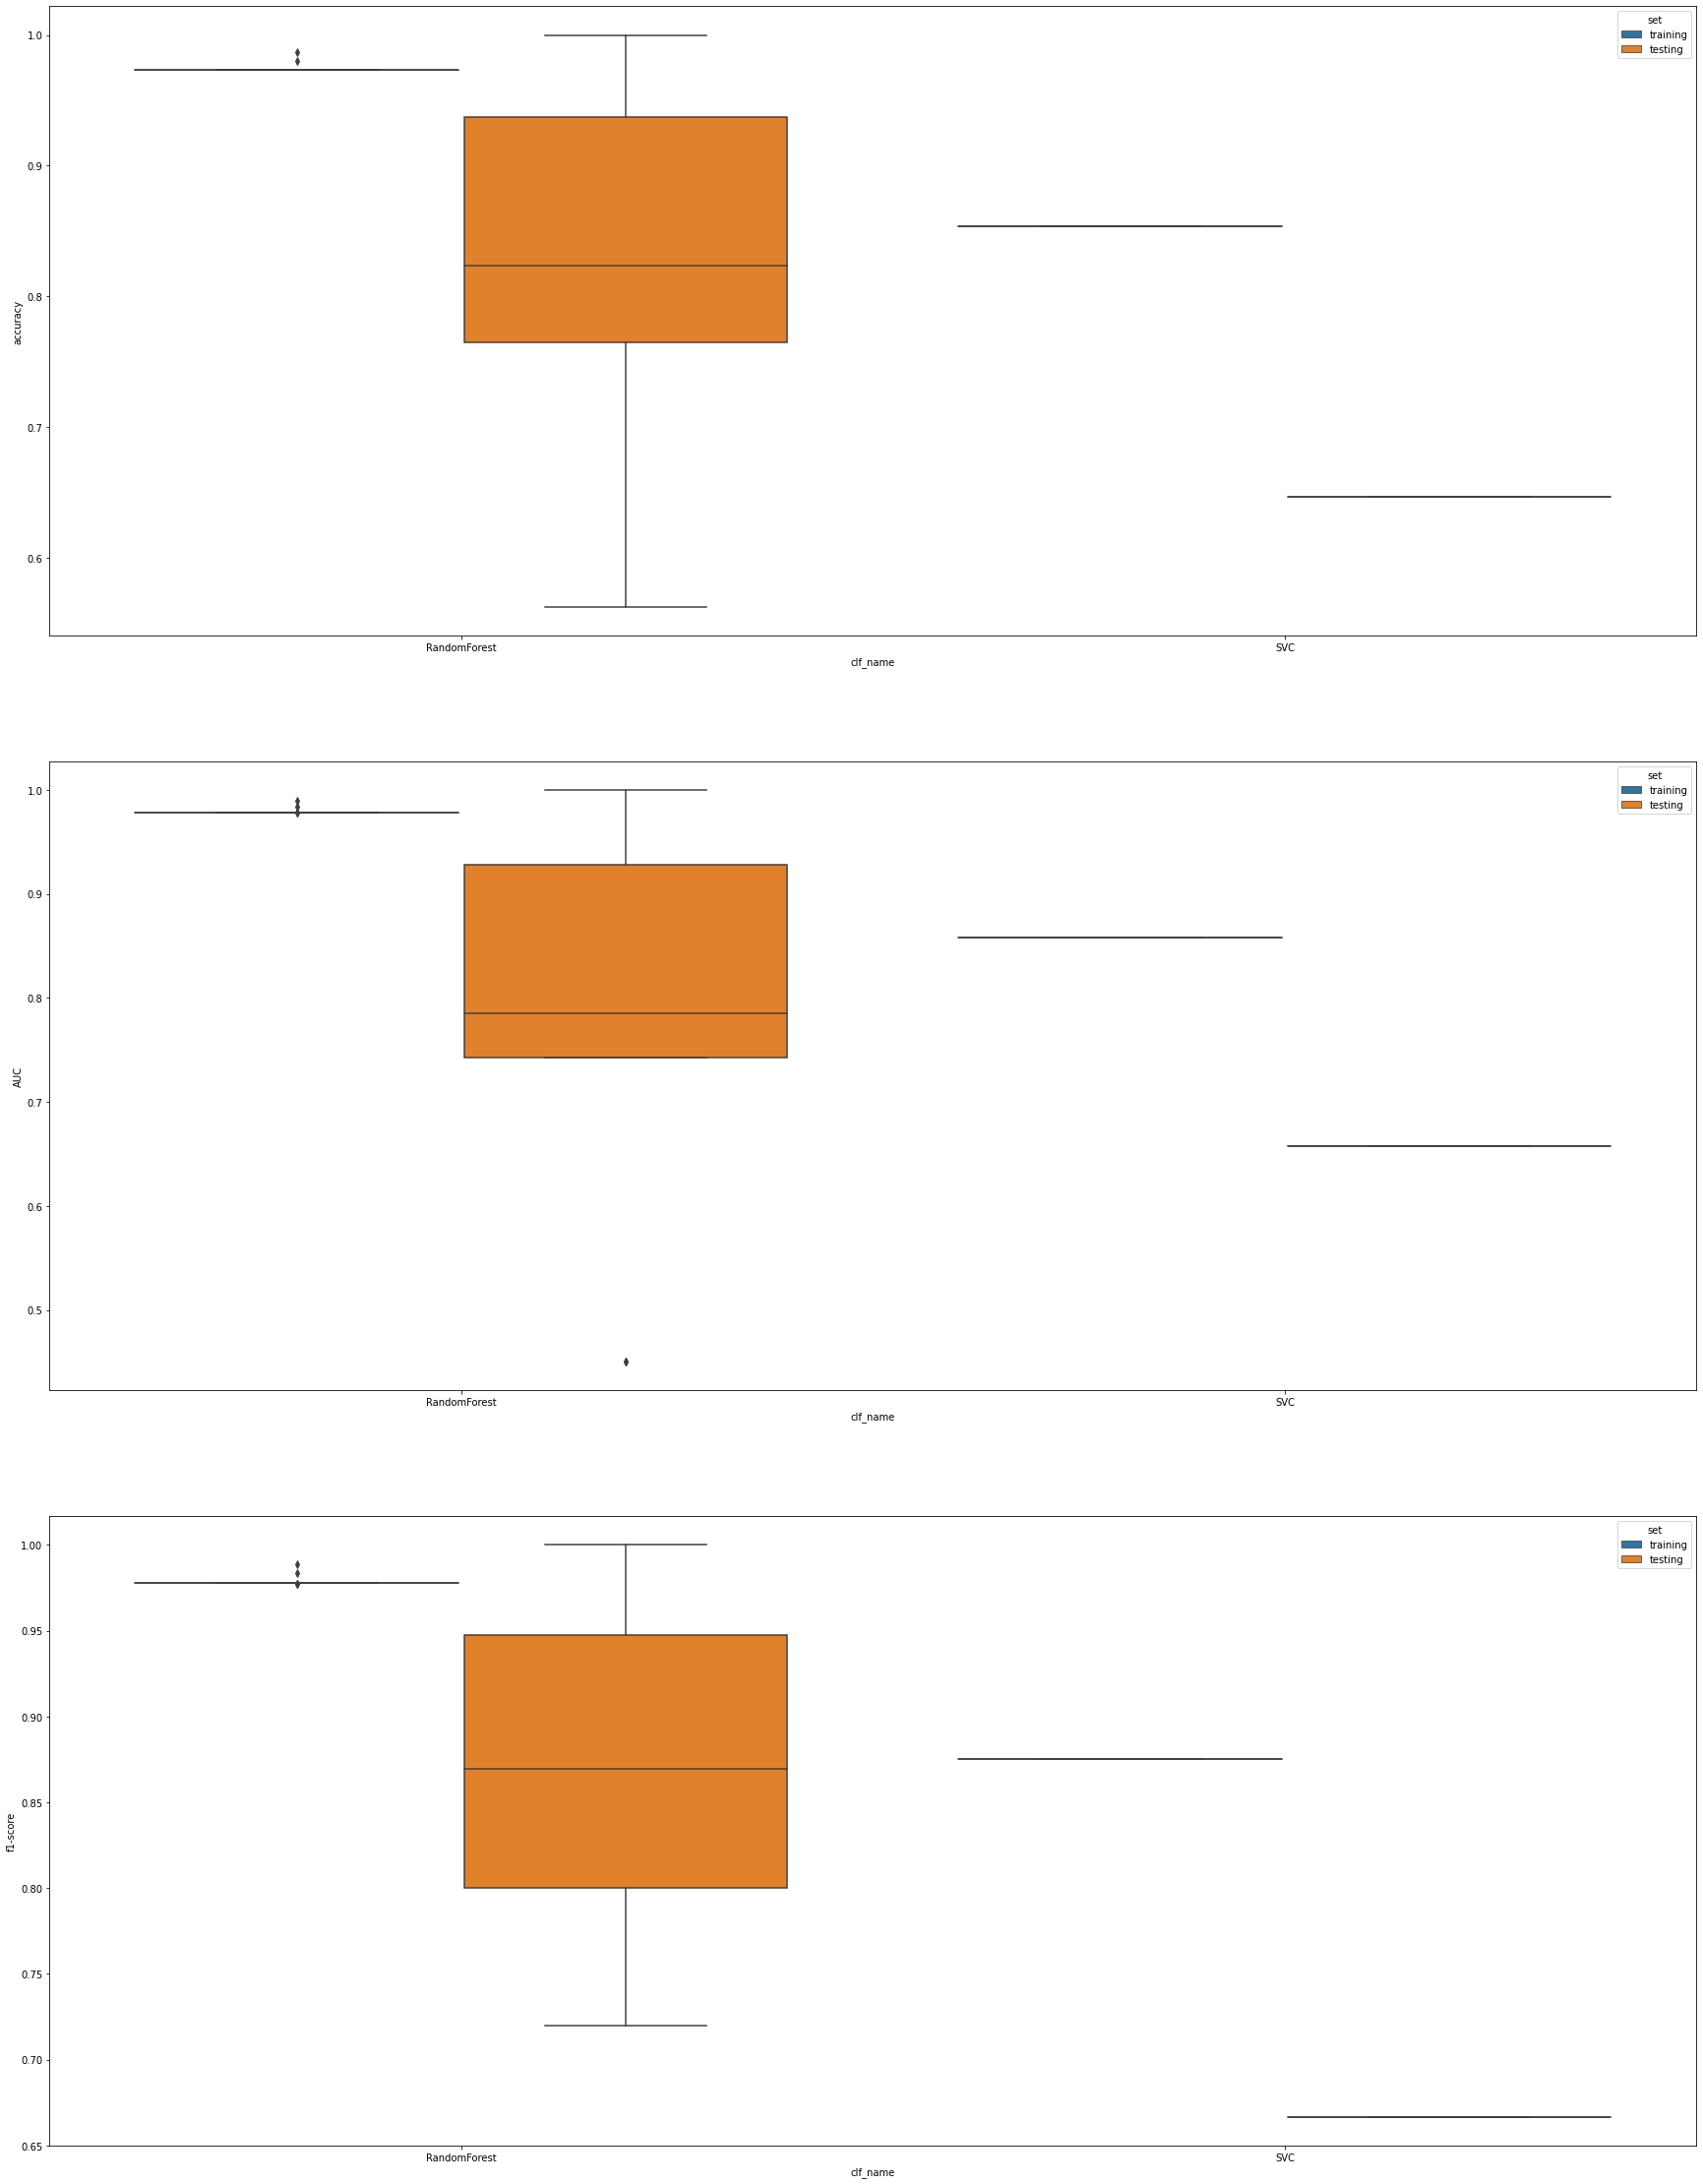

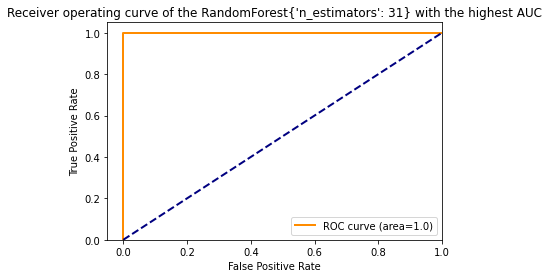

In [0]:
#load dataset
data_X, data_Y, Test_split = load_data(splits=10)

results_outer = list()
i=0
for design_index, test_index in Test_split.split(data_X, data_Y):
    i += 1
    print(f'Starting fold {i}') 
    X_design = data_X.iloc[design_index]
    Y_design = data_Y.iloc[design_index]
    
    X_test = data_X.iloc[test_index]
    Y_test = data_Y.iloc[test_index]

    # run preprocessing
    X_design, Y_design, X_test, Y_test = preprocessing_data(X_design, Y_design, X_test, Y_test)

    # run feature extraction
    X_design, Y_design_bin, X_test, Y_test_bin, feature_extractor = feature_extraction(X_design, Y_design, X_test, Y_test)
    print(f'after feature extraction {X_test.shape[1]} columns left')
    #print(X_design, Y_design_bin)

    # run classifier
    results_outer = classifiers(X_design, Y_design_bin, X_test, Y_test_bin, results_outer, feature_extractor)

# run evaluation
evaluation(results_outer)



# save data to csv for manual check
#X_design.to_csv('data_X.csv')
#Y_design.to_csv('data_Y.csv')




In [0]:
results_outer

[{'AUC': 0.9780219780219781,
  'accuracy': 0.9733333333333334,
  'clf_name': 'RandomForest',
  'f1-score': 0.9775280898876404,
  'feature_extractor': ac mean         0.800
  ac std           0.10
  AUC mean        0.808
  AUC std          0.10
  f1 mean         0.821
  f1 std           0.10
  rfecv        no_rfecv
  model           pca_8
  component           8
  Name: 3, dtype: object,
  'fpr': 'NaN',
  'parameters': {'n_estimators': 146},
  'set': 'training',
  'tpr': 'NaN'},
 {'AUC': 0.6666666666666667,
  'accuracy': 0.7647058823529411,
  'clf_name': 'RandomForest',
  'f1-score': 0.846153846153846,
  'feature_extracor': ac mean         0.800
  ac std           0.10
  AUC mean        0.808
  AUC std          0.10
  f1 mean         0.821
  f1 std           0.10
  rfecv        no_rfecv
  model           pca_8
  component           8
  Name: 3, dtype: object,
  'fpr': array([0.        , 0.66666667, 1.        ]),
  'parameters': {'n_estimators': 146},
  'set': 'testing',
  'tpr': array([

### Result